In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import pickle
!pip install SimpleITK
import SimpleITK as sitk
import CUSTOM
from CUSTOM import Vnet_3d, ImageDataLoader, SurvPredNet, ImageDataLoader_survival
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input

     |████████████████████████████████| 48.4 MB 1.3 MB/s 


In [7]:
def final_fun_1(input_img, mask_img, slice):
    """
    Given the zipped input_img and mask img path in .npy.gz format
    and given the slice of MRI image, model will predict the segmented mask and survival days of patient
    """
    
    vnet_model = None
    vnet_model = Vnet_3d(128,128,128,3, 8,0.2)

    vnet_model.load_weights(pretrained_model)

    fig, ax = plt.subplots(1,5, figsize = (20, 45))
    
    test_dataloader = ImageDataLoader('/'.join(input_img.split("/")[:-1])+"/", [input_img.split("/")[-1]] , '/'.join(mask_img.split("/")[:-1])+"/", [mask_img.split("/")[-1]], 1)
    img, msk = test_dataloader.__next__()

    #predicting segmented images
    pred_image = vnet_model.predict(np.reshape(img, (1,128,128,128,3)))
    n_slice=slice

    ax[0].imshow(img[0][:,:,n_slice, 0])
    ax[0].set_title('Image t1ce')

    ax[1].imshow(img[0][:,:,n_slice, 1])
    ax[1].set_title('Image t2')

    ax[2].imshow(img[0][:,:,n_slice, 2])
    ax[2].set_title('Image flair')

    msk = np.argmax(msk[0], axis=-1)
    ax[3].imshow(msk[:,:,n_slice])
    ax[3].set_title('Mask')

    pred = np.argmax(pred_image[0], axis=-1)
    ax[4].imshow(pred[:,:,n_slice])
    ax[4].set_title('Predicted Mask')

    plt.show()

    survival_model_files = open(survival_model_file, 'rb')
    age_normalizer, survival_normalizer = pickle.load(survival_model_files)
    
    input_img = Input((128,128,128,3))
    age_m = Input((1))
    
    survival_model = SurvPredNet(input_img,age_m)
    age = float(input("Enter the age of Patient "))

    age = age_normalizer.transform(np.array(age).reshape(1,-1))
    
    pred_age = survival_model.predict((np.reshape(img, (1,128,128,128,3)), age))
    pred_age = survival_normalizer.inverse_transform(np.array(pred_age).reshape(-1,1))[0]
    
    print("Expected survival of patient with Brain Tumor is: {} days".format(int(pred_age)))

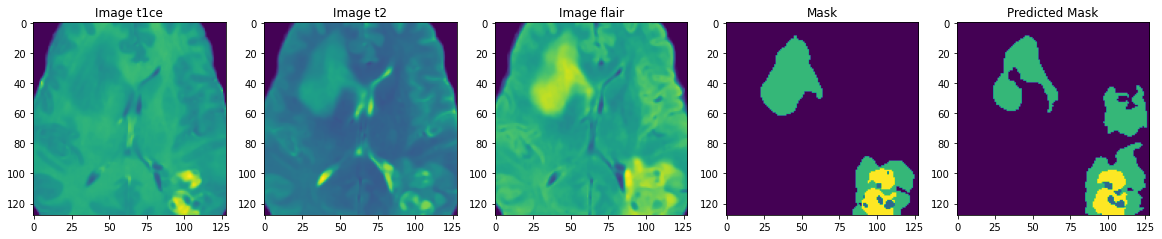

Enter the age of Patient 64
Expected survival of patient with Brain Tumor is: 1155 days


In [8]:
pretrained_model = "/content/drive/MyDrive/Brain_Tumor_Segmentation/vnet_model_2.h5"
image_path = "/content/drive/MyDrive/Brain_Tumor_Segmentation/Sample Data/image_BraTS20_Training_369.npy.gz"
mask_path = "/content/drive/MyDrive/Brain_Tumor_Segmentation/Sample Data/mask_BraTS20_Training_369.npy.gz"
survival_model_file = "/content/drive/MyDrive/Brain_Tumor_Segmentation/survival_model_files"

final_fun_1(image_path, mask_path, 64)